## Load data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import math
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, auc, log_loss
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
random_state= 123

In [3]:
with open ('age_model.pcl', 'rb') as handle:
    my_pipeline = pickle.load(handle)

In [4]:
my_pipeline[0]

{'1': 'TRAIN Datasets', '2': 'TEST Datasets'}

In [5]:
my_pipeline[1][0]

{'1': 'TRAIN_MODEL_FE', '2': 'TRAIN_MODEL_B_NUM', '3': 'TRAIN_MODEL_DPI'}

In [6]:
df = my_pipeline[1][1]
df

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
0,0.0,0.0,10.831324,1.001231,1.000303,5.324077,0.0,31.451311,1.226911,25.836335,...,0.0,4.210402,NaN,0.0,NaN,12.792268,NaN,0.0,4.0,1525928.0
1,0.0,0.0,9.974412,1.000840,1.000147,5.324077,0.0,0.000000,1.006293,13.330951,...,0.0,NaN,NaN,0.0,NaN,17.899284,NaN,NaN,4.0,1530471.0
2,0.0,0.0,12.103587,1.001149,1.000765,5.324077,0.0,10.624526,1.009837,4.981543,...,0.0,2.206949,NaN,0.0,NaN,NaN,NaN,0.0,3.0,1541528.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1542028.0
4,0.0,0.0,0.000000,0.000000,0.000000,1.480453,0.0,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,0.0,NaN,12.792268,NaN,NaN,5.0,1542203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146948,0.0,0.0,6.749902,0.000000,0.000000,5.324077,0.0,0.000000,0.000000,26.173097,...,0.0,1.480453,NaN,0.0,NaN,NaN,NaN,0.0,4.0,132486100.0
146949,0.0,0.0,4.786566,0.000000,0.000000,5.324077,0.0,0.000000,1.002164,24.389623,...,0.0,3.590290,NaN,0.0,NaN,NaN,NaN,0.0,3.0,132550466.0
146950,0.0,0.0,2.921812,0.000000,0.000000,5.324077,0.0,0.000000,0.000000,21.097312,...,0.0,2.206949,NaN,0.0,NaN,NaN,NaN,0.0,3.0,132551440.0
146951,0.0,0.0,0.000000,0.000000,0.000000,2.921812,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,132571143.0


In [7]:
df_test = my_pipeline[2][1]

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146953 entries, 0 to 146952
Columns: 817 entries, Ama_rchrgmnt_sum_max_mnt1 to abon_id
dtypes: float64(817)
memory usage: 916.0 MB


In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
reduce_mem_usage(df)
reduce_mem_usage(df_test)

Mem. usage decreased to 238.53 Mb (74.0% reduction)
Mem. usage decreased to 71.92 Mb (74.0% reduction)


,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
0,0.0,0.0,10.265625,0.000000,1.005859,5.324219,0.0,0.000000,1.008789,16.453125,...,0.000000,1.480469,NaN,0.0,NaN,12.789062,NaN,0.0,4.0,1539671.0
1,0.0,0.0,11.617188,1.001953,0.000000,5.324219,0.0,0.000000,1.004883,15.015625,...,0.000000,2.207031,NaN,0.0,NaN,12.789062,NaN,0.0,2.0,1554700.0
2,0.0,0.0,16.453125,0.000000,0.000000,5.324219,0.0,0.000000,1.083008,14.328125,...,0.000000,2.207031,NaN,0.0,NaN,12.789062,NaN,0.0,5.0,1570402.0
3,0.0,0.0,8.687500,0.000000,0.000000,5.324219,0.0,19.296875,1.091797,18.234375,...,1.000977,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,4.0,1580746.0
4,0.0,0.0,6.750000,0.000000,0.000000,5.324219,0.0,0.000000,1.083008,0.000000,...,0.000000,NaN,1.0,0.0,NaN,12.789062,NaN,NaN,2.0,1582781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44302,0.0,0.0,4.785156,0.000000,0.000000,5.324219,0.0,0.000000,1.058594,9.617188,...,13.632812,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,4.0,132355800.0
44303,0.0,0.0,4.785156,0.000000,0.000000,5.324219,0.0,0.000000,0.000000,21.093750,...,0.000000,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,2.0,132357376.0
44304,0.0,0.0,0.000000,0.000000,0.000000,4.785156,0.0,0.000000,1.006836,19.750000,...,0.000000,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,2.0,132361376.0
44305,0.0,0.0,3.589844,0.000000,0.000000,5.324219,0.0,0.000000,0.000000,21.093750,...,0.000000,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,5.0,132369800.0


## LightGBM baseline model

In [11]:
# Preparing target variable (as LGBM classes start with 0 but in our target - with 1, we subtract 1)
y_train_st = df['target'] -1
X_train = df.drop(['target', 'abon_id'],axis=1)

y_test_st = df_test['target'].astype(int) -1
X_test = df_test.drop(['target', 'abon_id'], axis=1)

In [12]:
gbm_model_base = lgb.LGBMClassifier()
gbm_model_base.fit(X_train, y_train_st)

y_train_pred = gbm_model_base.predict(X_train)
y_test_pred = gbm_model_base.predict(X_test)

y_train_prob = gbm_model_base.predict_proba(X_train)
y_test_prob = gbm_model_base.predict_proba(X_test)

In [13]:
def calculate_metrics(y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob):
    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    precision_train = precision_score(y_train, y_train_pred, average='weighted')
    precision_test = precision_score(y_test, y_test_pred, average='weighted')

    recall_train = recall_score(y_train, y_train_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')

    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    auc_train = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
    auc_test = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

    # Print metrics
    print(f"Training Accuracy: {accuracy_train*100:.2f}%")
    print(f"Test Accuracy: {accuracy_test*100:.2f}%")
    print(f"Training Precision (Weighted): {precision_train*100:.2f}%")
    print(f"Test Precision (Weighted): {precision_test*100:.2f}%")
    print(f"Training Recall (Weighted): {recall_train*100:.2f}%")
    print(f"Test Recall (Weighted): {recall_test*100:.2f}%")
    print(f"Training F1 Score (Weighted): {f1_train*100:.2f}%")
    print(f"Test F1 Score (Weighted): {f1_test*100:.2f}%")
    print(f"Training AUC: {auc_train*100:.2f}%")
    print(f"Test AUC: {auc_test*100:.2f}%")

In [14]:
calculate_metrics(y_train_st, y_test_st, y_train_pred, y_test_pred, y_train_prob, y_test_prob)

# Display probabilities
y_train_prob[:20].round(3)

Training Accuracy: 55.04%
Test Accuracy: 46.53%
Training Precision (Weighted): 55.00%
Test Precision (Weighted): 45.78%
Training Recall (Weighted): 55.04%
Test Recall (Weighted): 46.53%
Training F1 Score (Weighted): 54.37%
Test F1 Score (Weighted): 45.62%
Training AUC: 84.14%
Test AUC: 79.21%


array([[0.002, 0.13 , 0.401, 0.394, 0.072],
       [0.001, 0.011, 0.095, 0.297, 0.595],
       [0.009, 0.151, 0.465, 0.29 , 0.086],
       [0.018, 0.27 , 0.428, 0.178, 0.107],
       [0.021, 0.027, 0.104, 0.186, 0.663],
       [0.007, 0.031, 0.139, 0.331, 0.491],
       [0.013, 0.052, 0.229, 0.345, 0.361],
       [0.002, 0.065, 0.292, 0.369, 0.273],
       [0.006, 0.321, 0.445, 0.176, 0.052],
       [0.003, 0.04 , 0.206, 0.285, 0.466],
       [0.002, 0.038, 0.441, 0.251, 0.267],
       [0.02 , 0.225, 0.411, 0.223, 0.121],
       [0.017, 0.526, 0.408, 0.037, 0.012],
       [0.022, 0.096, 0.289, 0.259, 0.334],
       [0.013, 0.057, 0.147, 0.219, 0.564],
       [0.006, 0.082, 0.208, 0.3  , 0.404],
       [0.006, 0.139, 0.628, 0.187, 0.039],
       [0.008, 0.031, 0.055, 0.144, 0.761],
       [0.006, 0.029, 0.103, 0.274, 0.588],
       [0.003, 0.029, 0.163, 0.217, 0.589]])

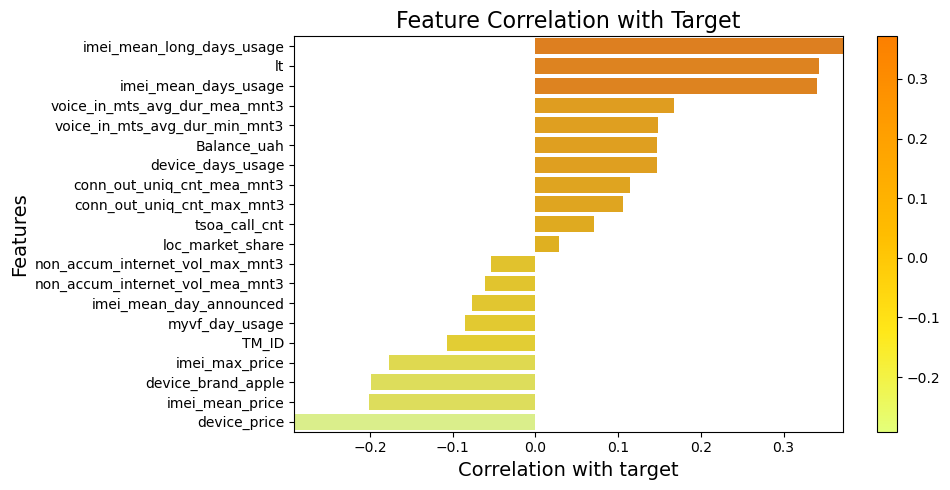

In [15]:
# Gathering the feature importances and correlations
feature_importances = gbm_model_base.feature_importances_
importances_series = pd.Series(feature_importances, index=df.drop(['target', 'abon_id'], axis=1).columns)
top_20_features = importances_series.sort_values(ascending=False)[:20].index
correlations = df[top_20_features].join(df['target']).corr()['target'].drop('target').sort_values(ascending=False)

# Create a DataFrame from correlations
corr_df = pd.DataFrame(correlations).reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)

# Update feature names in the DataFrame
corr_df['Feature'] = corr_df['Feature']

# Define colormap
cmap = cm.get_cmap('Wistia')
normalize = colors.Normalize(vmin=corr_df['Correlation'].min(), vmax=corr_df['Correlation'].max())
colormap = cmap(normalize(corr_df['Correlation'].values))

plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(data=corr_df, y='Feature', x='Correlation', palette=colormap)
bar_plot.set(xlim=(corr_df['Correlation'].min(), corr_df['Correlation'].max()))

# Adding a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])  # this line is necessary for the colorbar
plt.colorbar(sm)

plt.title('Feature Correlation with Target', fontsize=16)
plt.xlabel('Correlation with target', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig("plot.png")
plt.show()

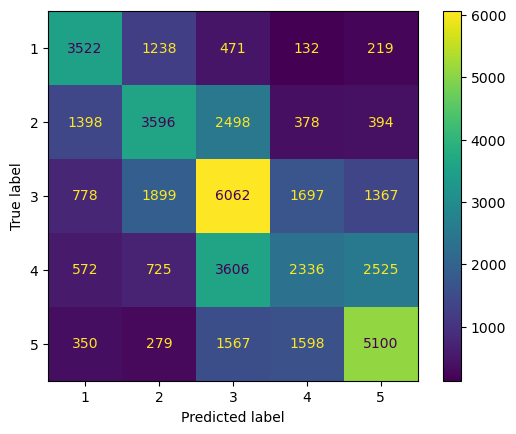

In [14]:
conf_matrix = confusion_matrix(y_test_st, y_test_pred)

# Create a confusion matrix display instance
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[1,2,3,4,5])

# Actually plot the confusion matrix
cm_display.plot()

##### As we can see, the model poorly identifies 2 and 4 class

## Feature selection and Data Cleaning and EDA

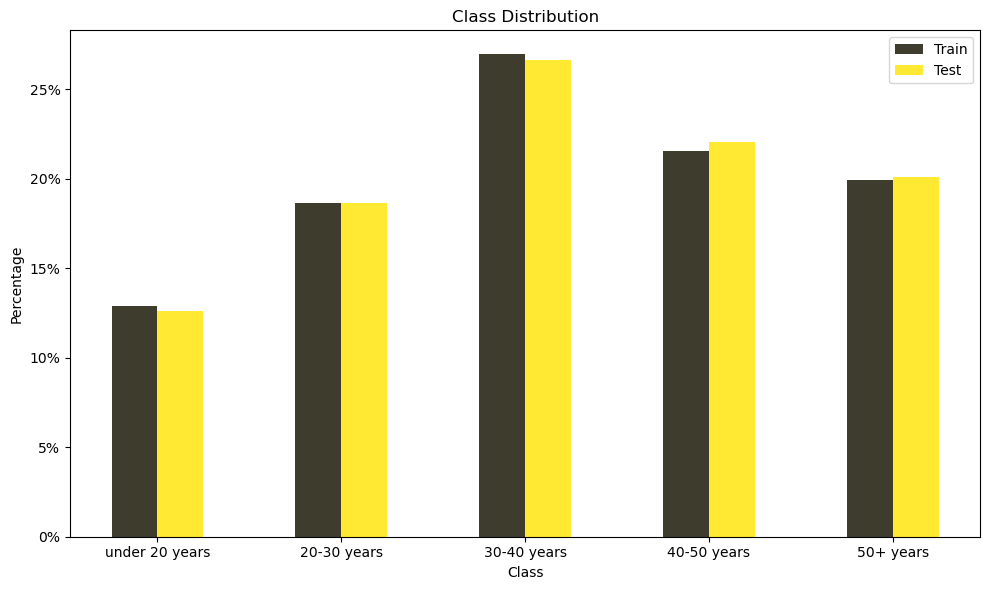

In [16]:
# Calculate the percentage instead of counts
df_target_percentage = df['target'].value_counts(normalize=True).rename('train')
df_test_target_percentage = df_test['target'].value_counts(normalize=True).rename('test')

# Concatenate train and test dataframes along column axis and reset index
combined_df = pd.concat([df_target_percentage, df_test_target_percentage], 
                        axis=1).reset_index().rename(columns={'index':'Class'})

# Sort the DataFrame by the 'Class' column
combined_df = combined_df.sort_values(by='Class')

# Map the class labels to the class names
class_names = {1: 'under 20 years', 2: '20-30 years', 3: '30-40 years', 4: '40-50 years', 5: '50+ years'}
combined_df['Class'] = combined_df['Class'].map(class_names)

n = len(combined_df)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Create a new numerical index for the x-axis
new_x = np.arange(n) 

# Add bars for 'train' with specified colors
rects1 = ax.bar(new_x - width/2, combined_df['train'], width, label='Train', color='#3E3C2D')

# Add bars for 'test' with specified colors
rects2 = ax.bar(new_x + width/2, combined_df['test'], width, label='Test', color='#FFE933')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_title('Class Distribution')
ax.set_xticks(new_x)
ax.set_xticklabels(combined_df['Class'])  # use the class names for the tick labels
ax.legend()

# Convert y-axis labels to percentage
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

fig.tight_layout()
plt.savefig("plot.png")
plt.show()

In [29]:
# Get feature importances
importances = gbm_model_base.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Filter out features with importance <= 0
feature_importances_df = feature_importances_df[feature_importances_df['Importance'] > 1]

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Display the DataFrame
print(feature_importances_df[:20])


                             Feature  Importance
606                               lt         617
648             imei_mean_days_usage         367
622                   myvf_day_usage         339
651          imei_mean_day_announced         338
639                  imei_mean_price         264
641                   imei_max_price         252
604                      Balance_uah         191
322    voice_in_mts_avg_dur_mea_mnt3         176
654        imei_mean_long_days_usage         175
632                 loc_market_share         166
655               device_brand_apple         158
634                device_days_usage         152
107       conn_out_uniq_cnt_mea_mnt3         149
605                            TM_ID         143
624                    tsoa_call_cnt         141
562    voice_in_mts_avg_dur_min_mnt3         138
573  non_accum_internet_vol_mea_mnt3         127
653                     device_price         126
103       conn_out_uniq_cnt_max_mnt3         121
510  non_accum_inter

In [30]:
# take out dataset with important features
important_features = feature_importances_df['Feature'].tolist()
X_imp_gbm = X_train[important_features]

#####  We have dublicated abon_id and the interesting thing is that the same user belongs to different age category(class) 
##### and if we evaluate it according to the most important feature, the lifetime is also different

In [19]:
df[df.duplicated('abon_id', keep=False)].sort_values('abon_id')[['lt', 'abon_id', 'target']][-10:]

,lt,abon_id,target
145101,5.160156,119083456.0,1
145102,5.160156,119083456.0,1
145173,5.179688,119212464.0,5
145174,5.175781,119212464.0,3
145432,5.156250,120067400.0,1
145433,5.156250,120067400.0,4
145472,5.160156,120168152.0,5
145473,5.160156,120168152.0,5
146824,3.740234,131164080.0,3
146825,NaN,131164080.0,2


##### We have some Nan values in lt feature. Maybe the reason is that device is hacked and the one doesn't plan to make calls from it 

In [20]:
df[df['lt'].isna()]['lt']

919      NaN
4141     NaN
8119     NaN
8500     NaN
9158     NaN
          ..
146868   NaN
146887   NaN
146892   NaN
146894   NaN
146897   NaN
Name: lt, Length: 600, dtype: float16

In [21]:
df[df['lt'].isna()]

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_Traf_mn_out_v_Min,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id
919,0.0,0.0,10.265625,0.000000,0.0,5.324219,0.0,0.000000,1.016602,0.000000,...,0.000000,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,5,1926430.0
4141,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.0,NaN,17.90625,NaN,NaN,5,6008286.0
8119,0.0,0.0,9.671875,0.000000,1.0,5.324219,0.0,0.000000,1.201172,16.765625,...,0.000000,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,5,9688050.0
8500,0.0,0.0,10.265625,1.006836,0.0,5.324219,0.0,21.656250,1.088867,14.085938,...,13.289062,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,4,9877278.0
9158,0.0,0.0,16.296875,1.000977,1.0,5.324219,0.0,20.109375,1.264648,23.437500,...,0.000000,3.589844,NaN,0.0,NaN,NaN,NaN,0.0,3,10044255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146868,NaN,NaN,NaN,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,131496416.0
146887,0.0,0.0,14.609375,0.000000,0.0,2.207031,0.0,0.000000,0.000000,16.453125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,131677640.0
146892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,131783512.0
146894,0.0,0.0,7.964844,0.000000,0.0,1.480469,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,131800000.0


In [36]:
# Create a boolean mask for rows where the count of non-NaN values is less than or equal to 3
mask = df.notna().sum(axis=1) <= 3

# Get the rows which do not meet this criteria
df_clean = df[~mask]

# Perform the same on test set 
mask_test = df_test.notna().sum(axis=1) <= 3
df_test_clean = df_test[~mask_test]

In [37]:
# I decided to drop rows where lt is NaN
df_clean = df.dropna(subset=['lt'])
df_test_clean = df_test.dropna(subset=['lt'])

In [38]:
# Sort the dataframe by 'abon_id' and 'lt'.
df_sorted = df_clean.sort_values(['abon_id', 'lt'], ascending=[True, False])

# Drop duplicates, keeping only the first entry (which is the one with the highest 'lt').
df_no_duplicates = df_sorted.drop_duplicates(subset='abon_id', keep='first')

# Same on test set 
df_test_sorted = df_test_clean.sort_values(['abon_id', 'lt'], ascending=[True, False])
df_test_no_duplicates = df_test_sorted.drop_duplicates(subset='abon_id', keep='first')

<AxesSubplot:>

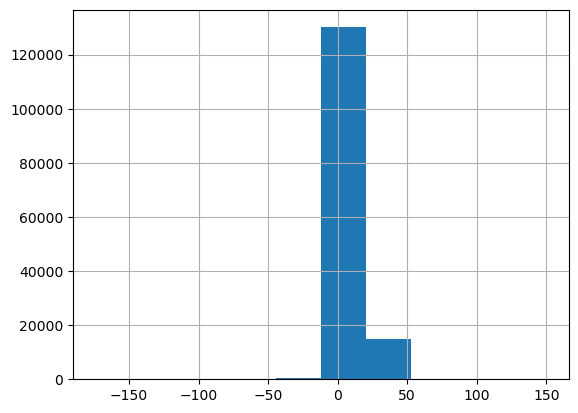

In [48]:
# In feature importance we have Balance as top important feature but It seems to me that the account balance is not directly related to user's age, each person can change balance
#everyday so i will not include it to important features 
df_no_duplicates.Balance_uah.hist()

In [15]:
df_no_duplicates.shape

(145806, 817)

In [53]:
df_test_no_duplicates.shape

(44099, 817)

##### Analyzing unique in and out contacts features, and std to see people of what age are most sociable and stability of this process during time

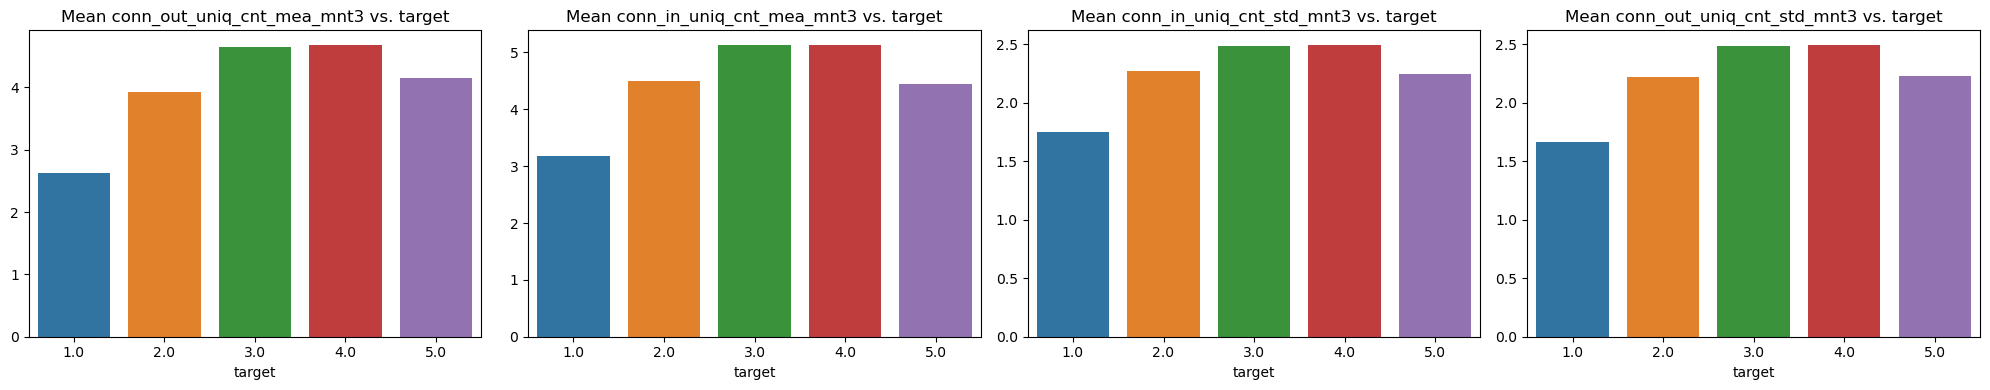

In [32]:
features_contacts = ['conn_out_uniq_cnt_mea_mnt3', 'conn_in_uniq_cnt_mea_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'conn_out_uniq_cnt_std_mnt3']

# Calculate the number of rows needed for subplots
rows = math.ceil(len(features_contacts) / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, rows*4)) 

# 'axes' is a 2D array, so we flatten it for ease of iteration
axes = axes.flatten()
target = 'target'
for ax, feature in zip(axes, features_contacts):
    # We calculate the mean of each feature per class
    mean_per_class = df_no_duplicates.groupby(target)[feature].mean()
    sns.barplot(ax=ax, x=mean_per_class.index, y=mean_per_class.values)
    ax.set_title('Mean ' + feature + ' vs. ' + target)

# Remove empty subplots
for i in range(len(features_contacts), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

##### Analyzing incoming and outcoming chargeable calls and in/out calls in general to see if different age groups have different calling patterns.

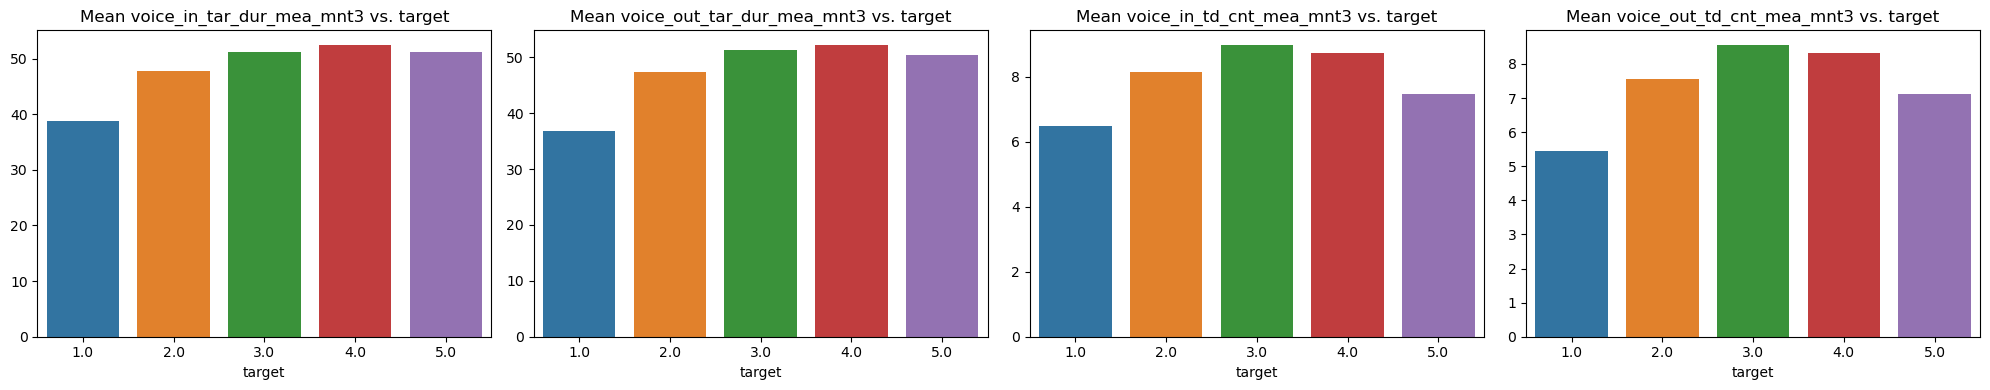

In [33]:
features_voice = ['voice_in_tar_dur_mea_mnt3', 'voice_out_tar_dur_mea_mnt3', 'voice_in_td_cnt_mea_mnt3', 'voice_out_td_cnt_mea_mnt3']

# Calculate the number of rows needed for subplots
rows = math.ceil(len(features_voice) / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, rows*4)) 

# 'axes' is a 2D array, so we flatten it for ease of iteration
axes = axes.flatten()
target = 'target'
for ax, feature in zip(axes, features_voice):
    # We calculate the mean of each feature per class
    mean_per_class = df_no_duplicates.groupby(target)[feature].mean()
    sns.barplot(ax=ax, x=mean_per_class.index, y=mean_per_class.values)
    ax.set_title('Mean ' + feature + ' vs. ' + target)

# Remove empty subplots
for i in range(len(features_voice), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

##### Analyzing features concerning imei. Higher mean prices might suggest users with higher income or those who prioritize high-end technology. On the contrary, lower mean prices could suggest budget-conscious users. Users with devices that have more recent announcement dates are likely to be early adopters who stay up-to-date with the latest technology.

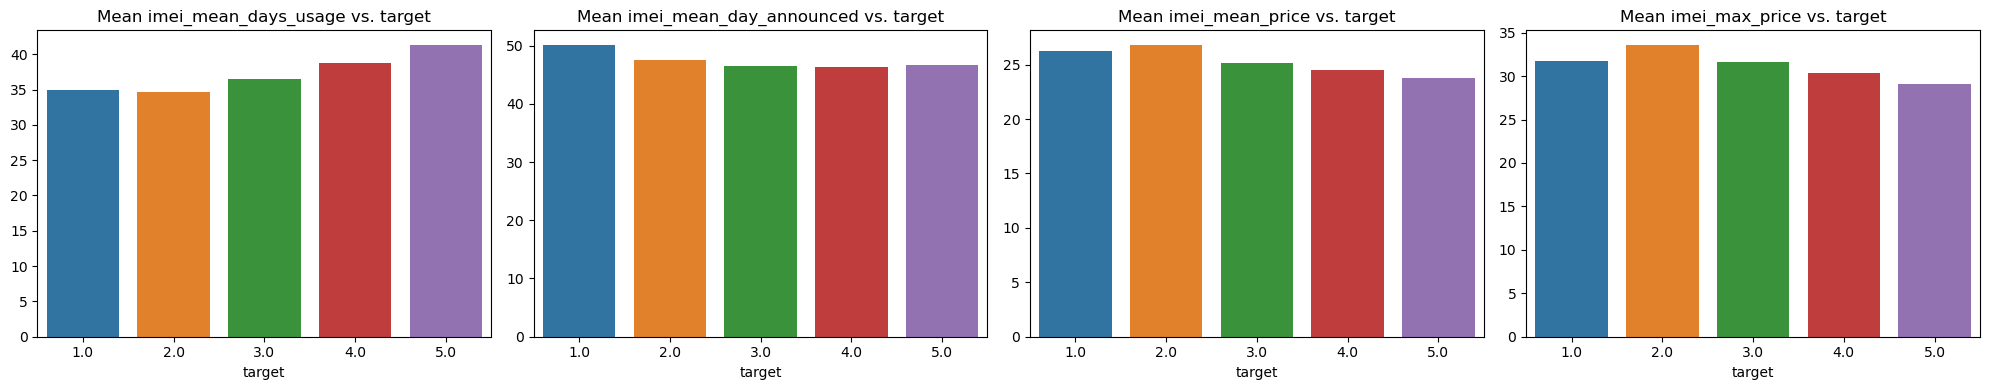

In [34]:
features_imei = ['imei_mean_days_usage', 'imei_mean_day_announced', 'imei_mean_price', 'imei_max_price']

# Calculate the number of rows needed for subplots
rows = math.ceil(len(features_imei) / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, rows*4)) 

# 'axes' is a 2D array, so we flatten it for ease of iteration
axes = axes.flatten()
target = 'target'
for ax, feature in zip(axes, features_imei):
    # We calculate the mean of each feature per class
    mean_per_class = df_no_duplicates.groupby(target)[feature].mean()
    sns.barplot(ax=ax, x=mean_per_class.index, y=mean_per_class.values)
    ax.set_title('Mean ' + feature + ' vs. ' + target)

# Remove empty subplots
for i in range(len(features_imei), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

##### Analyzing call duration among users and volume of data transmitted outside the service package

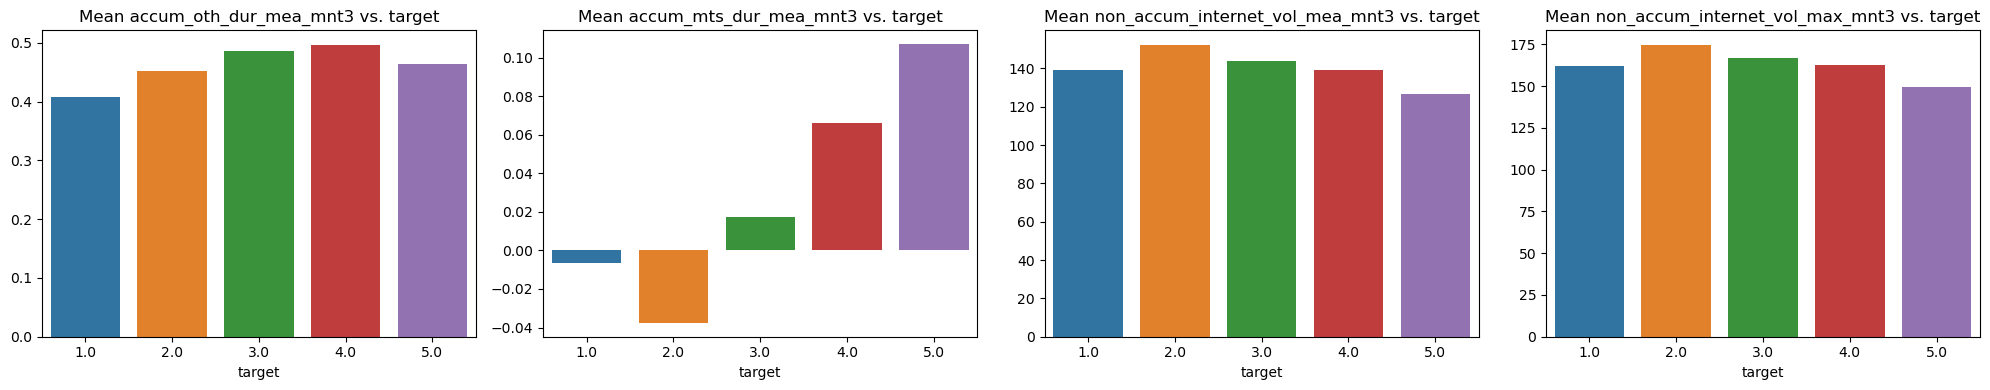

In [35]:
features_call_dur_inet = ['accum_oth_dur_mea_mnt3', 'accum_mts_dur_mea_mnt3', 'non_accum_internet_vol_mea_mnt3', 'non_accum_internet_vol_max_mnt3']

# Calculate the number of rows needed for subplots
rows = math.ceil(len(features_call_dur_inet) / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, rows*4)) 

# 'axes' is a 2D array, so we flatten it for ease of iteration
axes = axes.flatten()
target = 'target'
for ax, feature in zip(axes, features_call_dur_inet):
    # We calculate the mean of each feature per class
    mean_per_class = df_no_duplicates.groupby(target)[feature].mean()
    sns.barplot(ax=ax, x=mean_per_class.index, y=mean_per_class.values)
    ax.set_title('Mean ' + feature + ' vs. ' + target)

# Remove empty subplots
for i in range(len(features_call_dur_inet), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

##### Other interesting features. We can see here that older people are more prone to call to contact center compared to younger. Younger people when changing tariff plan are more prone to change mb volume, while older groups change volume of minutes for call. The amount of consumed content services is higher among older. Concerning device price and apple brand which price tag is higher we can see user's spending habits or their preferences for high-end devices. Older users have been using their devices for a longer duration compared to younger users, what is obvious. 

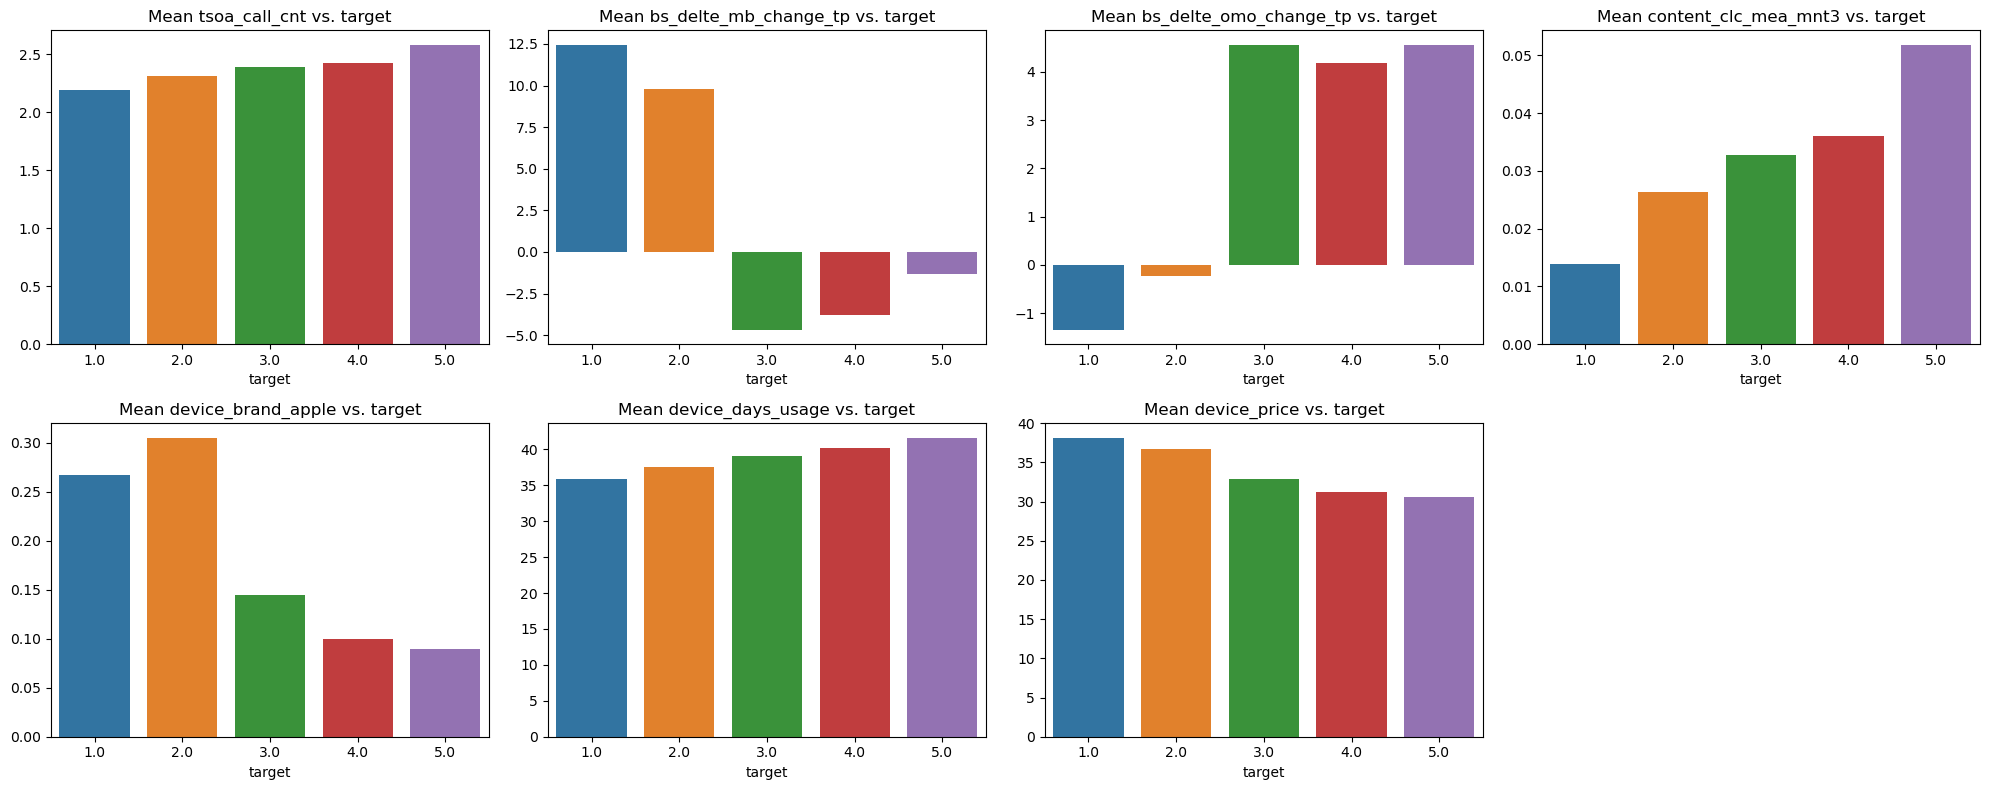

In [36]:
# List of features for analysis
features_other = ['tsoa_call_cnt', 'bs_delte_mb_change_tp', 'bs_delte_omo_change_tp', 'content_clc_mea_mnt3',
                  'device_brand_apple', 'device_days_usage', 'device_price']

import math

# Calculate the number of rows needed for subplots
rows = math.ceil(len(features_other) / 4)

fig, axes = plt.subplots(rows, 4, figsize=(20, rows*4))  # Change the number of columns here

# 'axes' is a 2D array, so we flatten it for ease of iteration
axes = axes.flatten()

# Replace 'target' with the actual name of your target variable
target = 'target'

for ax, feature in zip(axes, features_other):
    # We calculate the mean of each feature per class
    mean_per_class = df_no_duplicates.groupby(target)[feature].mean()
    sns.barplot(ax=ax, x=mean_per_class.index, y=mean_per_class.values)
    ax.set_title('Mean ' + feature + ' vs. ' + target)

# Remove empty subplots
for i in range(len(features_other), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [14]:
df_no_duplicates.to_pickle('df_no_duplicates.pkl')
df_test_no_duplicates.to_pickle('df_test_no_duplicates.pkl')

In [25]:
df_no_duplicates = pd.read_pickle('df_no_duplicates.pkl')
df_test_no_duplicates = pd.read_pickle('df_test_no_duplicates.pkl')

In [26]:
y_train = df_no_duplicates['target'] -1
y_test = df_test_no_duplicates['target'] -1

#### I will also try K-Best technique to select most important features. This technique needs Nan to be imputed so I will use simple -1 imputation here 

In [31]:
X_train = df_no_duplicates.copy()
X_train = X_train.fillna(-1)
X_train = X_train.drop(['target', 'abon_id'], axis=1)

# Define the number of features we want to keep
k = int(X_train.shape[1] / 8) 

# Initialize SelectKBest
selector = SelectKBest(score_func=f_classif, k=k)

# Fit and transform X to get a new dataframe X_new with only the k best features
X_new = selector.fit_transform(X_train, y_train) 

# Get the column names of the selected features
mask = selector.get_support() #list of booleans
new_features = [] # The list of K best features

for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_features.append(feature)

# To get the scores of each feature, we use `.scores_` attribute
scores = selector.scores_

# Creating a DataFrame for visualization 
df_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': scores})
df_scores = df_scores.sort_values(by='Score', ascending=False)

# Print the features and their scores in descending order of score
print(df_scores[:20])

# Get the selected features data frame
X_selected_features = pd.DataFrame(X_new, columns=new_features)


                             Feature        Score
606                               lt  5811.927343
654        imei_mean_long_days_usage  5204.769381
648             imei_mean_days_usage  4946.291674
615         DNZ_DAYS_from_last_year5  1688.986454
619   DNZ_MAX_days_closed_loan_year5  1598.691409
620        DNZ_COUNT_open_loan_year5  1524.174475
617      DNZ_COUNT_closed_loan_year5  1415.247766
614  DNZ_MEAN_days_closed_loan_year5  1391.080503
609         DNZ_DAYS_from_last_year2  1365.842890
107       conn_out_uniq_cnt_mea_mnt3  1210.297310
610   DNZ_MAX_days_closed_loan_year2  1205.347463
613        DNZ_COUNT_open_loan_year2  1196.315942
611   DNZ_STD_days_closed_loan_year5  1169.604579
192       conn_out_uniq_cnt_mea_mnt1  1156.975843
618      DNZ_COUNT_closed_loan_year2  1137.224376
322    voice_in_mts_avg_dur_mea_mnt3  1122.465293
465        conn_in_uniq_cnt_mea_mnt3  1118.183723
538       conn_out_uniq_cnt_max_mnt1  1104.229734
309       conn_out_uniq_cnt_min_mnt3  1100.157153


In [52]:
X_selected_features.shape

(145806, 101)

In [33]:
# Get top 101 features which Lightgbm base model has identified
top_101_features = feature_importances_df['Feature'].iloc[:101].tolist()

# Get intersection
intersection = set(top_101_features).intersection(set(X_selected_features.columns))

print(f"Number of common features: {len(intersection)}")

# Get unique features in X_selected_features and X_imp_gbm
unique_in_X_selected = set(X_selected_features.columns) - intersection
unique_in_X_imp_gbm = set(top_101_features) - intersection

print(f"Number of unique features in X_selected_features: {len(unique_in_X_selected)}")
print(f"Number of unique features in X_imp_gbm: {len(unique_in_X_imp_gbm)}")

Number of common features: 42
Number of unique features in X_selected_features: 59
Number of unique features in X_imp_gbm: 59


In [34]:
# Create a new dataframe with only intersection features
df_important_features = df_no_duplicates[list(intersection)]

# Create a new dataframe with only intersection features in the test set
df_test_important_features = df_test_no_duplicates[list(intersection)]

In [35]:
df_important_features.shape

(145806, 42)

In [36]:
df_test_important_features.shape

(44099, 42)

### Shap

In [ ]:
shap_model = LGBMClassifier(n_estimators=450, learning_rate=0.2, max_depth=5, num_leaves=40, min_data_in_leaf=100,
                          feature_fraction=0.4, bagging_fraction=0.9, lambda_l1=60, lambda_l2=60)

shap_model.fit(df_important_features, y_train)

In [38]:
y_train_pred = shap_model.predict(df_important_features)
y_test_pred = shap_model.predict(df_test_important_features)

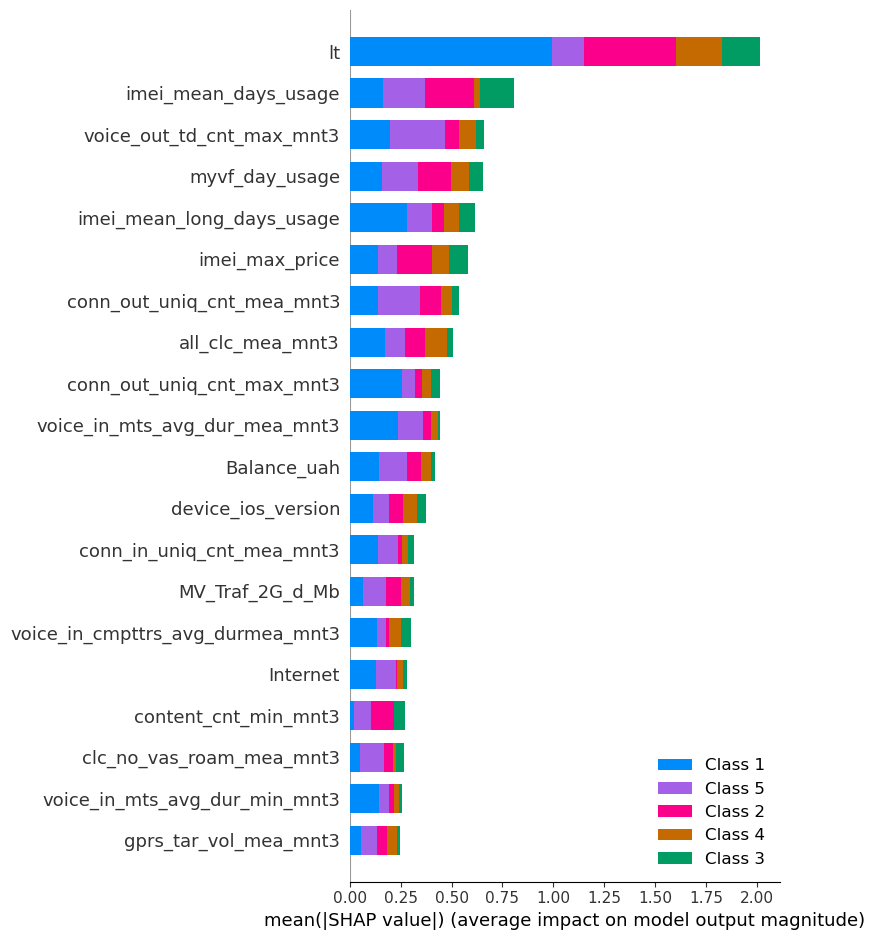

In [50]:
import shap

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(df_important_features)

# Define the class labels in the desired order
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Plot the summary plot with sorted feature names and SHAP values, specifying class names
shap.summary_plot(shap_values, df_important_features, plot_type="bar", max_display=20, class_names=class_names)

##### The next thing i decided to do is to add one feature from those we have not selected from df and with one feature per iteration calculate it's info gain, then select some more quantity of features that influence positively on our model 

In [63]:
from sklearn.metrics import mutual_info_score

# Starting set of features
important_features = df_important_features.columns.tolist()

# All possible features
all_features = df_no_duplicates.columns.tolist()

# Removing already selected features
remaining_features = [feature for feature in all_features if feature not in important_features and feature != 'target']

# Store information gains
info_gains = []

X = df_important_features
y = y_train

# Training the initial model
model = lgb.LGBMClassifier()
model.fit(X, y)

# Initial prediction
y_pred = model.predict(df_test_important_features)

# Initial score
initial_score = mutual_info_score(y_test, y_pred)

for feature in remaining_features:
    # Add the new feature
    X_new = X.copy()
    X_new[feature] = df_no_duplicates[feature]

    df_test_new = df_test_important_features.copy()
    df_test_new[feature] = df_test_no_duplicates[feature]

    # Retrain the model
    model.fit(X_new, y)

    # Make predictions
    y_pred_new = model.predict(df_test_new)

    # Calculate the new score
    new_score = mutual_info_score(y_test, y_pred_new)

    # Calculate the information gain
    info_gain = new_score - initial_score

    # Save the information gain
    info_gains.append((feature, info_gain))

# Sort the features by information gain
info_gains.sort(key=lambda x: x[1], reverse=True)

# Print the top 50 features
for feature, gain in info_gains[:50]:
    print(f'Feature: {feature}, Info Gain: {gain}')


Feature: imei_mean_day_announced, Info Gain: 0.006654030644934084
Feature: non_accum_internet_vol_max_mnt3, Info Gain: 0.0045510689604098264
Feature: non_accum_internet_vol_mea_mnt3, Info Gain: 0.004467845864379982
Feature: TM_ID, Info Gain: 0.0038373767869247233
Feature: voice_mts_in_nrest_part_mea_mnt3, Info Gain: 0.003781989800285074
Feature: non_accum_internet_vol_max_mnt1, Info Gain: 0.0033948788328475588
Feature: voice_mts_in_nwork_part_mea_mnt3, Info Gain: 0.0033716251854959967
Feature: non_accum_internet_vol_std_mnt3, Info Gain: 0.0032919222555549132
Feature: non_accum_internet_vol_mea_mnt1, Info Gain: 0.003048335514552608
Feature: data_3g_tar_vol_std_mnt3, Info Gain: 0.0030185082317340794
Feature: voice_in_td_cnt_std_mnt3, Info Gain: 0.0029888697801712105
Feature: MV_ap_s, Info Gain: 0.002981452885055247
Feature: data_3g_tar_vol_max_mnt3, Info Gain: 0.0029078886900039125
Feature: voice_out_tar_dur_mea_mnt1, Info Gain: 0.0028292477315955966
Feature: MV_DOU_PPM_VF, Info Gain: 0.

In [241]:
# Get the top features from info_gains
feats_top = [feature for feature, gain in info_gains[:75]]

# Remove the features that already exist in df_important_features
feats_top_filtered = [feature for feature in feats_top if feature not in df_important_features.columns]

# Add the filtered features to df_important_features
df_important = pd.concat([df_important_features, df_no_duplicates[feats_top_filtered]], axis=1)
df_test_important = pd.concat([df_test_important_features, df_test_no_duplicates[feats_top_filtered]], axis=1)

In [228]:
# Save the training set with important features
df_important.to_pickle('df_important.pkl')
# Save the test set with important features
df_test_important.to_pickle('df_test_important.pkl')

In [17]:
df_important.shape

(145806, 117)

In [18]:
# drop Balance feature as in my opinion it is not an adequate feature for our business goal
df_important = df_important.drop('Balance_uah', axis=1)
df_test_important = df_test_important.drop('Balance_uah', axis=1)

In [21]:
# Missing values count
df_important.isnull().sum().sort_values(ascending=False).head(50)

day_end_gba                         132714
device_ios_version                  130821
DNZ_STD_days_closed_loan_year5      130132
DNZ_COUNT_closed_loan_year2         125637
device_price                        120505
DNZ_MAX_days_closed_loan_year5      119237
DNZ_MEAN_days_closed_loan_year5     119237
DNZ_MIN_days_closed_loan_year5      119237
DNZ_COUNT_closed_loan_year5         118781
DNZ_DAYS_from_last_year5            118781
tsoa_call_cnt                       111691
Internet                            105814
MV_DOU_PPM_VF                        65730
MV_ap_omo_out_v                      60682
MV_ap_pstn_out_v                     60682
MV_ap_mn_out_v                       60682
MV_ap_s                              60682
MV_ap_innet_out_v                    60682
device_height_mm                     34938
device_width_mm                      34938
device_has_lte                       34938
loc_cnt_events                       33689
min_paym_6_month                     22895
max_paym_6_

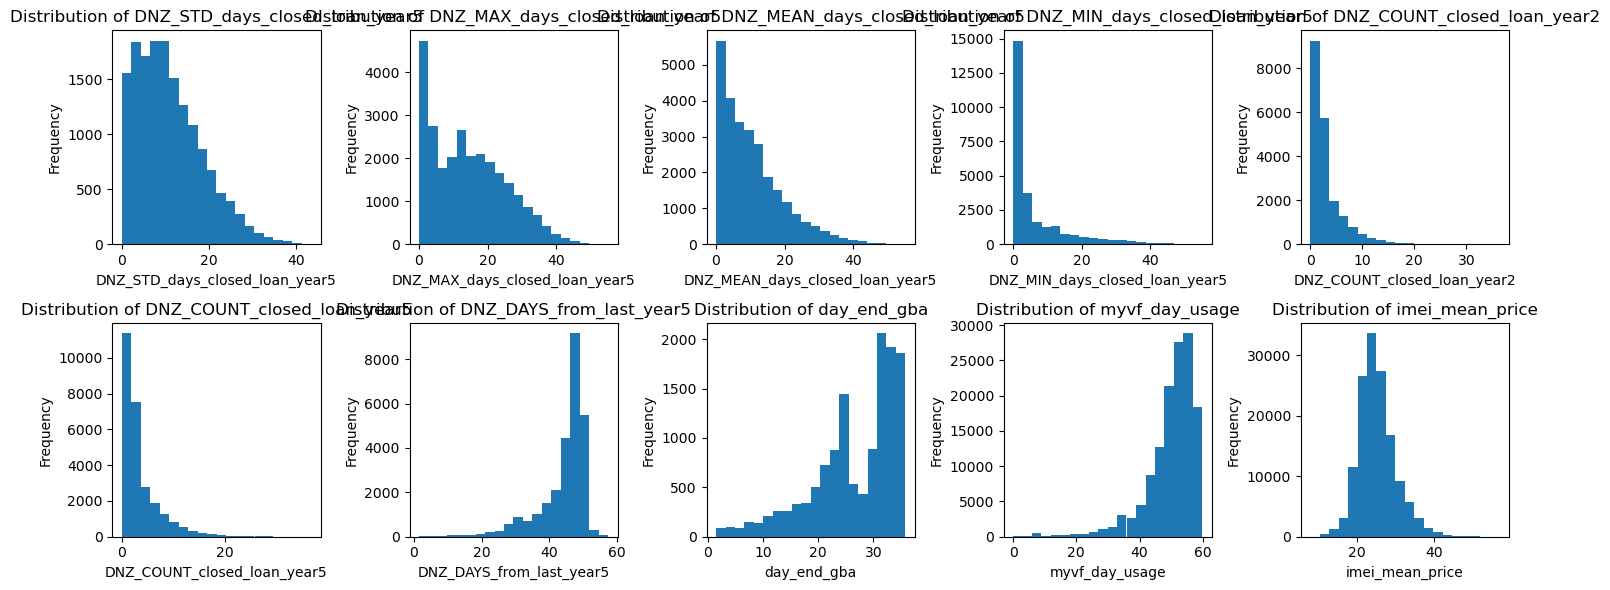

In [149]:
# If the distribution of these features is approximately normal and there are no significant outliers,
# then imputing with the mean or median of the non-missing values will be appropriate, if no - I will log the distribution
features = ['DNZ_STD_days_closed_loan_year5', 'DNZ_MAX_days_closed_loan_year5', 'DNZ_MEAN_days_closed_loan_year5',
            'DNZ_MIN_days_closed_loan_year5', 'DNZ_COUNT_closed_loan_year2', 'DNZ_COUNT_closed_loan_year5',
            'DNZ_DAYS_from_last_year5', 'day_end_gba', 'myvf_day_usage', 'imei_mean_price']

# Determine the number of rows and columns for the grid layout
num_plots = len(features)
num_rows = (num_plots + 4) // 5  # Round up to the nearest integer
num_cols = min(num_plots, 5)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Plot histograms for each feature
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.hist(df[feature], bins=20)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

In [19]:
def preprocess_missings(df):
    features = ['DNZ_STD_days_closed_loan_year5', 'DNZ_MAX_days_closed_loan_year5', 'DNZ_MEAN_days_closed_loan_year5',
                'DNZ_MIN_days_closed_loan_year5', 'DNZ_COUNT_closed_loan_year2', 'DNZ_COUNT_closed_loan_year5',
                'DNZ_DAYS_from_last_year5', 'day_end_gba', 'myvf_day_usage', 'imei_mean_price']
    for feature in features:
        df[feature] = np.log1p(df[feature])
    
    # Since these features represent data traffic usage, imputing the missing values with zeros might be appropriate,
    # indicating no data traffic during the respective periods. Tsoa - no activity. IOS - no ios.  
    features_to_impute = ['device_ios_version', 'tsoa_call_cnt', 'Internet', 'MV_Traf_3G_d_Mb', 'MV_Traf_2G_d_Mb']
    for feature in features_to_impute:
        df[feature].fillna(0, inplace=True)
        
    # Create an instance of SimpleImputer with strategy='most_frequent'
    imputer = SimpleImputer(strategy='most_frequent')

    # Impute the missing values in 'device_has_lte' with the most frequent value
    df['device_has_lte'] = imputer.fit_transform(df[['device_has_lte']])
    
    # And the rest with median 
    df = df.fillna(df.median())
    return df

In [20]:
df_imputed = preprocess_missings(df_important)
df_test_imputed = preprocess_missings(df_test_important)

#### Feature Engineering

##### (I tried to create some new features, but unfortunately the metrics dropped after they were added) Different age groups might have different preferences for device size. For example, younger users might prefer larger devices for gaming and media consumption, while older users might prefer smaller devices for their portability and ease of use.

In [135]:
# # Compute diagonal size
# df_important['device_diagonal_mm'] = np.sqrt(df_important['device_width_mm']**2 + df_important['device_height_mm']**2)
# df_test_important['device_diagonal_mm'] = np.sqrt(df_test_important['device_width_mm']**2 + df_test_important['device_height_mm']**2)

In [137]:
# # Define a function to categorize the iOS version
# def categorize_ios_version(version):
#     if version < 8.0:
#         return "Older"
#     elif version >= 8.0 and version < 12.0:
#         return "Intermediate"
#     else:
#         return "Newer"

# # Apply the categorization function to the 'device_ios_version' column
# df_important['ios_version_category'] = df_important['device_ios_version'].apply(categorize_ios_version)
# df_test_important['ios_version_category'] = df_test_important['device_ios_version'].apply(categorize_ios_version)

# # A small constant
# SMALL_CONST = 1e-10

# # Creating a new feature - the ratio of incoming to outgoing unique contacts
# X['ratio_in_out_contacts'] = X['conn_out_uniq_cnt_max_mnt1'] / (X['conn_out_uniq_cnt_mea_mnt3'] + SMALL_CONST)
# X_test['ratio_in_out_contacts'] = X_test['conn_out_uniq_cnt_max_mnt1'] / (X_test['conn_out_uniq_cnt_mea_mnt3'] + SMALL_CONST)

# # Define a function to determine contact type
# def determine_contact_type(row):
#     if row['ratio_in_out_contacts'] > 1:
#         return 'receiver'
#     elif row['ratio_in_out_contacts'] < 1:
#         return 'sender'
#     else:
#         return 'balanced'

# # Apply the function to each row
# X['contact_type'] = X.apply(determine_contact_type, axis=1)
# X_test['contact_type'] = X_test.apply(determine_contact_type, axis=1)
# X = pd.get_dummies(X, columns=['contact_type'])
# X_test = pd.get_dummies(X_test, columns=['contact_type'])

In [25]:
gbm_model_9 = lgb.LGBMClassifier()
gbm_model_9.fit(df_imputed, y_train)

y_train_pred = gbm_model_9.predict(df_imputed)
y_test_pred = gbm_model_9.predict(df_test_imputed)

y_train_prob = gbm_model_9.predict_proba(df_imputed)
y_test_prob = gbm_model_9.predict_proba(df_test_imputed)

calculate_metrics(y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob)

Training Accuracy: 52.80%
Test Accuracy: 44.72%
Training Precision (Weighted): 52.70%
Test Precision (Weighted): 45.48%
Training Recall (Weighted): 52.80%
Test Recall (Weighted): 44.72%
Training F1 Score (Weighted): 52.03%
Test F1 Score (Weighted): 43.68%
Training AUC: 82.80%
Test AUC: 78.08%


# Work with DPI dataset and B-Num

#### Load data

In [55]:
bnum_df = my_pipeline[1][2]
bnum_df

,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,abon_id
0,b'380445990777',1.480453,0.000000,24.988835,0.000000,0.000000,0.000000,1525928.0
1,b'380672368404',3.590290,0.000000,27.675014,0.000000,0.000000,0.000000,1525928.0
2,b'380977770109',3.590290,2.206949,29.743454,28.641258,0.000000,0.000000,1525928.0
3,b'chokolovka',0.000000,0.000000,0.000000,0.000000,0.000000,1.480453,1525928.0
4,b'dsns ukr',0.000000,0.000000,0.000000,0.000000,0.000000,3.590290,1525928.0
...,...,...,...,...,...,...,...,...
803263,b'4567890',0.000000,0.000000,0.000000,0.000000,1.480453,0.000000,132550466.0
803264,b'facebook',0.000000,0.000000,0.000000,0.000000,0.000000,2.921812,132550466.0
803265,b'telegram',0.000000,0.000000,0.000000,0.000000,0.000000,1.480453,132550466.0
803266,b'xiaomi',0.000000,0.000000,0.000000,0.000000,0.000000,2.206949,132550466.0


In [56]:
dpi_df = my_pipeline[1][3]
dpi_df

,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt,abon_id
0,115.0,45.380309,109.520418,27.008638,3.0,1525928.0
1,175.0,41.132912,54.181259,14.421684,5.0,1525928.0
2,240.0,103.767138,144.185283,59.978002,16.0,1525928.0
3,246.0,18.296309,1.418743,1.480453,1.0,1525928.0
4,254.0,57.651477,74.731171,28.531262,19.0,1525928.0
...,...,...,...,...,...,...
7058441,1127.0,15.986197,5.458114,1.480453,1.0,131296645.0
7058442,1353.0,1.480453,5.886177,1.480453,1.0,131296645.0
7058443,1373.0,25.490224,21.106426,4.786566,2.0,131296645.0
7058444,1462.0,20.202157,85.495002,9.669721,1.0,131296645.0


In [57]:
bnum_df_test = my_pipeline[2][2]

In [58]:
dpi_df_test = my_pipeline[2][3]

In [59]:
reduce_mem_usage(dpi_df)
reduce_mem_usage(bnum_df)
reduce_mem_usage(bnum_df_test)
reduce_mem_usage(dpi_df_test)

Mem. usage decreased to 94.24 Mb (70.8% reduction)
Mem. usage decreased to 18.39 Mb (62.5% reduction)
Mem. usage decreased to  5.61 Mb (62.5% reduction)
Mem. usage decreased to 28.48 Mb (70.8% reduction)


,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt,abon_id
0,175.0,60.625000,166.500000,9.671875,1.0,1539671.0
1,240.0,81.812500,97.500000,51.593750,27.0,1539671.0
2,246.0,78.125000,68.625000,47.968750,30.0,1539671.0
3,254.0,169.625000,216.000000,70.562500,30.0,1539671.0
4,257.0,54.000000,48.843750,23.093750,17.0,1539671.0
...,...,...,...,...,...,...
2133272,2018.0,26.687500,49.562500,9.671875,9.0,131098968.0
2133273,2046.0,77.250000,137.500000,66.812500,26.0,131098968.0
2133274,2536.0,6.300781,43.562500,6.750000,3.0,131098968.0
2133275,2556.0,30.859375,29.468750,4.785156,1.0,131098968.0


In [60]:
# for further testing
bnum_df_test.to_pickle('bnum_df_test.pkl')
dpi_df_test.to_pickle('dpi_df_test.pkl')

## Feature Engineering, Data Cleaning, EDA

#### BNum df

In [26]:
bnum_df['bnum'] = bnum_df['bnum'].apply(lambda x: x.decode('utf-8'))
bnum_df_test['bnum'] = bnum_df_test['bnum'].apply(lambda x: x.decode('utf-8'))

In [27]:
# compute how often every service was used 
service_counts = bnum_df['bnum'].value_counts()

In [28]:
# set maximum rows to display
pd.set_option('display.max_rows', 100)

# print the output
print(service_counts[:100])

dsns ukr        72616
ukraine         67034
novaposhta      23045
privatbank      22064
oschadbank      13825
e-health        13060
google           9566
facebook         9502
fishka           8325
taxi-838         8043
275              7842
uklon            7521
monobank         7507
111              7379
raiffeisen       6688
3700             6478
alfabank         6447
colins           6239
1020             5947
allo             5914
277              5893
ukrposhta        5875
epicentrk        5868
rozetka          5222
pumb             4691
ukrgasbank       3269
apteka911        3194
otp bank         3170
microsoft        3086
pmml             3074
kyivstar         3038
foxtrot.ua       3032
zsu              3021
a-bank           3005
viber            2766
infoshina        2690
sport life       2680
729              2660
whatsapp         2659
apple            2620
wog              2573
telegram         2561
authmsg          2464
silpo            2403
varus            2346
tiktok    

##### In this section i have analysed main ways of users interaction with the service. I also looked at the distribution of each service by class to understand whether information about this service would contribute to determining age 

In [29]:
merged = pd.merge(bnum_df, df_no_duplicates, on='abon_id', how='left')

In [30]:
merged[merged.bnum=='epicentrk' ][['call_cnt_out', 'call_cnt_in', 'call_dur_out', 'call_dur_in',
       'cnt_sms_out', 'cnt_sms_in']].describe()

,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in
count,5868.0,5868.0,5868.0,5868.0,5868.0,5868.000000
mean,0.0,0.0,0.0,0.0,0.0,5.582031
std,0.0,0.0,0.0,0.0,0.0,1.125000
min,0.0,0.0,0.0,0.0,0.0,1.480469
25%,0.0,0.0,0.0,0.0,0.0,5.828125
50%,0.0,0.0,0.0,0.0,0.0,5.828125
75%,0.0,0.0,0.0,0.0,0.0,5.828125
max,0.0,0.0,0.0,0.0,0.0,22.296875


In [31]:
# Get the size of each group
group_sizes = merged[merged.bnum=='moneyveo'].groupby('target').size()

# Calculate the total size
total_size = group_sizes.sum()

# Calculate the percentage for each group and round to 2 decimal places
group_percentages = ((group_sizes / total_size) * 100).round(1)

# Print the result
print(group_percentages)

target
1.0    12.7
2.0    44.4
3.0    25.5
4.0    11.9
5.0     5.5
dtype: float64


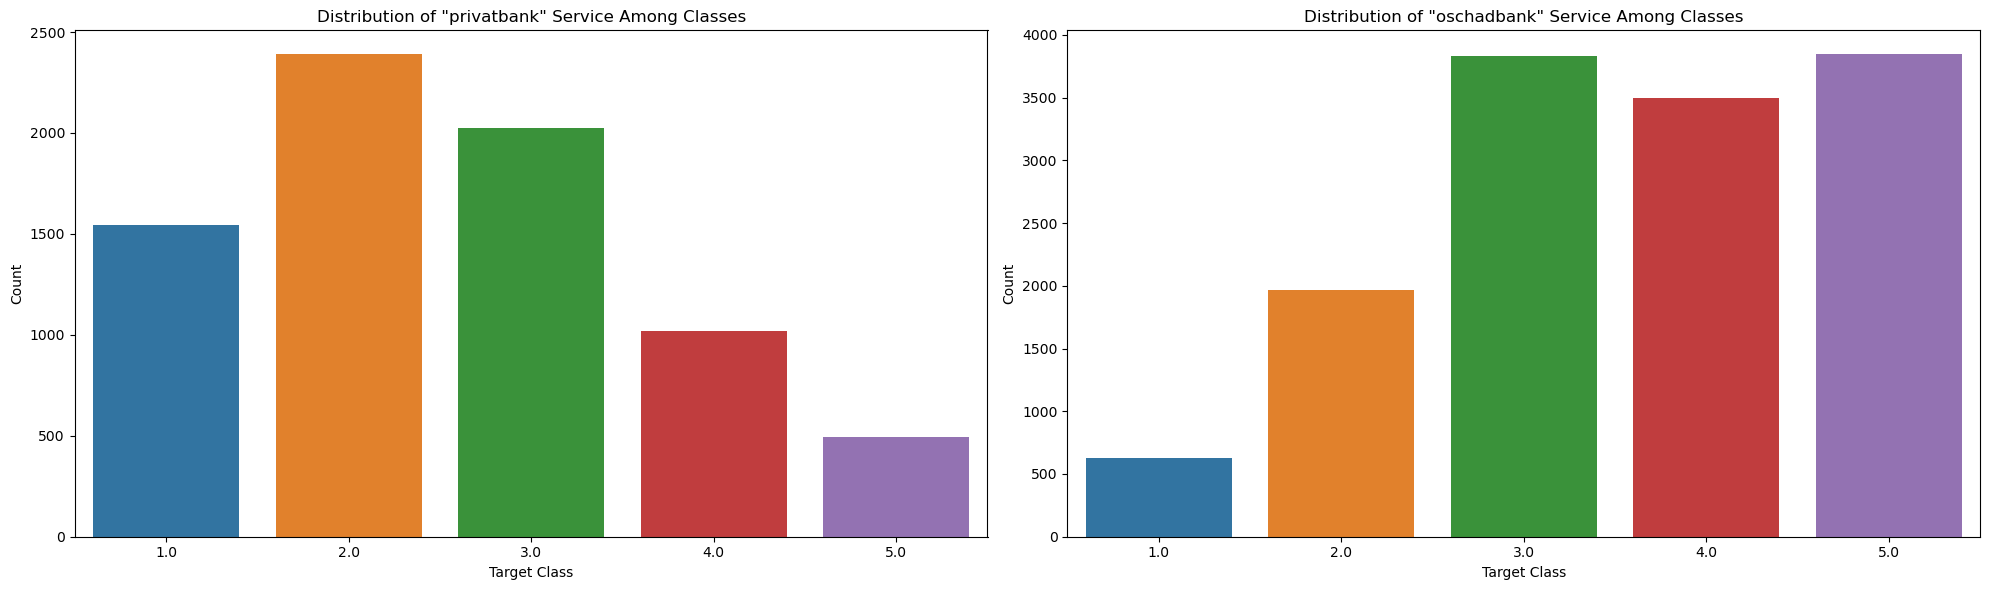

In [32]:
# I wanted to display two plots side by side to see if the services have similar contribution 
plt.figure(figsize=(20, 6))

# Create the first subplot for 'monobank'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
service_counts = merged[merged.bnum=='monobank'].groupby('target').size().reset_index(name='count')
sns.barplot(x='target', y='count', data=service_counts)
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of "privatbank" Service Among Classes')

# Create the second subplot for 'oschadbank'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
service_counts = merged[merged.bnum=='oschadbank'].groupby('target').size().reset_index(name='count')
sns.barplot(x='target', y='count', data=service_counts)
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of "oschadbank" Service Among Classes')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()


#### After the analysis, it turned out that there are services that can distinguish specific classes well. that's why I didn't take all the top ones, but chose from them those that will help the model where it doubts. For example, such services as e-health, google, taxi-838, 275, 111, fishka, allo, most of banks, humana, sportlife are distinguished by a margin of 3rd class, such as glovo, moneyveo, apple, pmml, binance, uklon, monobank - 2, and such as facebook, tiktok, pmml - 1. 

In [33]:
# List of services 
selected_services = ['dsns ukr', 'ukraine', 'novaposhta', 'privatbank', 'oschadbank', 'e-health', 
                     'google', 'facebook', 'fishka', 'taxi-838', '275', 'uklon', 'monobank', '111',
                     'raiffeisen', '3700', 'alfabank', 'colins', '1020', 'allo', '277', 'ukrposhta',
                     'epicentrk', 'rozetka', 'pumb', 'apteka911', 'microsoft', 'pmml', 'kyivstar', 
                     'viber', 'infoshina', 'sport life', '729', 'whatsapp', 'apple', 'wog', 'telegram',
                     'authmsg', 'tiktok', 'binance', 'humana', 'moneyveo']

# New dataframe for transpose matrix
pivot_bnum = pd.DataFrame()

# For each service from the selected services, we will create a column for each characteristic
for service in selected_services:
    # Filter rows for current service
    service_df = bnum_df[bnum_df['bnum'] == service].copy()
    
    # Rename columns
    service_df.rename(columns={
        'call_cnt_out': f'call_cnt_out_{service}',
        'call_cnt_in': f'call_cnt_in_{service}',
        'call_dur_out': f'call_dur_out_{service}',
        'call_dur_in': f'call_dur_in_{service}',
        'cnt_sms_out': f'cnt_sms_out_{service}',
        'cnt_sms_in': f'cnt_sms_in_{service}',
    }, inplace=True)
    
    # Drop the 'bnum' column as it's no longer needed
    service_df.drop(columns='bnum', inplace=True)
    
    # If pivot_bnum_df is still empty, assign service_df to it
    # otherwise, merge the dataframes on 'abon_id'
    if pivot_bnum.empty:
        pivot_bnum = service_df
    else:
        pivot_bnum = pivot_bnum.merge(service_df, on='abon_id', how='outer')

# Fill NaN values with 0
pivot_bnum.fillna(0, inplace=True)

In [34]:
# Get a boolean mask for columns in the dataframe where all values are zero
zero_mask = (pivot_bnum == 0).all()

# Get a list of all zero columns names
zero_columns = zero_mask[zero_mask].index.tolist()
pivot_bnum.drop(columns=zero_columns, inplace=True)

In [35]:
pivot_bnum.drop_duplicates(subset='abon_id', keep='first', inplace=True)
pivot_bnum.shape

(109778, 55)

In [36]:
# Make the same for bnum_test set  
# New dataframe for transpose matrix
pivot_bnum_test = pd.DataFrame()

# For each service from the selected services, we will create a column for each characteristic
for service in selected_services:
    # Filter rows for current service
    service_df = bnum_df_test[bnum_df_test['bnum'] == service].copy()
    
    # Rename columns
    service_df.rename(columns={
        'call_cnt_out': f'call_cnt_out_{service}',
        'call_cnt_in': f'call_cnt_in_{service}',
        'call_dur_out': f'call_dur_out_{service}',
        'call_dur_in': f'call_dur_in_{service}',
        'cnt_sms_out': f'cnt_sms_out_{service}',
        'cnt_sms_in': f'cnt_sms_in_{service}',
    }, inplace=True)
    
    # Drop the 'bnum' column as it's no longer needed
    service_df.drop(columns='bnum', inplace=True)
    
    # If pivot_bnum_test is still empty, assign service_df to it
    # otherwise, merge the dataframes on 'abon_id'
    if pivot_bnum_test.empty:
        pivot_bnum_test = service_df
    else:
        pivot_bnum_test = pivot_bnum_test.merge(service_df, on='abon_id', how='outer')

# Fill NaN values with 0
pivot_bnum_test.fillna(0, inplace=True)

# Identify the common columns between the pivot_bnum and pivot_bnum_test dataframes
common_columns = pivot_bnum.columns.intersection(pivot_bnum_test.columns)

# Keep only the common columns in pivot_bnum_test
pivot_bnum_test = pivot_bnum_test[common_columns]


In [37]:
pivot_bnum_test.drop_duplicates(subset='abon_id', keep='first', inplace=True)
pivot_bnum_test.shape

(33121, 55)

In [39]:
# Merge df_imputed with df_no_duplicates on abon_id to get this column back
df_imputed['abon_id'] = df_no_duplicates['abon_id']
df_merged_with_bnum = df_imputed.merge(pivot_bnum, on='abon_id', how='left')
df_merged_with_bnum.shape

(145806, 171)

In [38]:
df_test_imputed['abon_id'] = df_test_no_duplicates['abon_id']
df_test_merged_with_bnum = df_test_imputed.merge(pivot_bnum_test, on='abon_id', how='left')
df_test_merged_with_bnum.shape

(44099, 171)

In [40]:
df_merged_with_bnum.to_pickle('df_merged_with_bnum.pkl')
df_test_merged_with_bnum.to_pickle('df_test_merged_with_bnum.pkl')

### dpi_df (Applications dataset)

In [48]:
# Calculating most used apps among users, choosing top 13 
app_usage_counts = dpi_df.groupby('Application')['SUM_of_Count_events'].sum()
top_apps = app_usage_counts.nlargest(13).index.tolist()

In [47]:
# Merge dpi df with our main df to get target for analysis
merged_2 = pd.merge(dpi_df, df_no_duplicates, on='abon_id', how='left')

##### Next I have analysed proportions among groups

In [48]:
# Get the size of each group
group_sizes = merged_2[merged_2.Application==739.0].groupby('target').size()

# Calculate the total size
total_size = group_sizes.sum()

# Calculate the percentage for each group and round to 2 decimal places
group_percentages = ((group_sizes / total_size) * 100).round(1)

# Print the result
print(group_percentages)

target
1.0    10.5
2.0    18.9
3.0    28.3
4.0    22.4
5.0    19.9
dtype: float64


#### Considering top apps i see the same situation. Most apps are widely used by 3 class, next 4, 2 and less used among 1 class. So i decided to choose apps which are more widely used by different classes. For example:app 320.0 is more used by 3 then 2 and 1, app 1375 - more popular in 2 and less in 3 and 1 and so on 

In [49]:
# Set max rows displayed in output for better visualisation
pd.set_option('display.max_rows', None)

# Define the number of top apps you want to consider
top_apps_number = 100

# Get top apps based on their counts
top_apps = app_counts.head(top_apps_number).index.tolist()

# Calculate the percentage for each group and round to 2 decimal places
app_target_percentages = merged_2[merged_2['Application'].isin(top_apps)].groupby(['Application', 'target']).size().reset_index(name='Counts')
app_target_percentages['Total Counts'] = app_target_percentages.groupby('Application')['Counts'].transform('sum')
app_target_percentages['Percentage'] = (app_target_percentages['Counts'] / app_target_percentages['Total Counts'] * 100).round(2)

# Sort the dataframe by Application and Percentage in descending order
app_target_percentages.sort_values(['Total Counts', 'Application', 'Percentage'], ascending=[False, True, False], inplace=True)

# Group by Application and get the top 2 rows for each group
distinct_apps_max_percentage = app_target_percentages.groupby('Application').head(3)

# Print the result
print(distinct_apps_max_percentage)


     Application  target  Counts  Total Counts  Percentage
37         258.0     3.0   32510        118963       27.33
38         258.0     4.0   26059        118963       21.91
39         258.0     5.0   23219        118963       19.52
122        677.0     3.0   32387        118494       27.33
123        677.0     4.0   25971        118494       21.92
124        677.0     5.0   23140        118494       19.53
77         546.0     3.0   31165        113915       27.36
78         546.0     4.0   25005        113915       21.95
79         546.0     5.0   22304        113915       19.58
17         240.0     3.0   30921        112569       27.47
18         240.0     4.0   24779        112569       22.01
19         240.0     5.0   22065        112569       19.60
127        678.0     3.0   30624        111566       27.45
128        678.0     4.0   24510        111566       21.97
129        678.0     5.0   21767        111566       19.51
132        690.0     3.0   30461        111155       27.

In [49]:
# Define selected applications and add to top 13 applications
selected_apps = [258.0, 897.0, 175.0, 868.0, 320.0, 1399.0, 1379.0, 1375.0]
union_apps = list(set(selected_apps) | set(top_apps))

In [57]:
# SElect only abon_id that are present in df imputed
dpi_df = dpi_df[dpi_df['abon_id'].isin(df_imputed['abon_id'])]
dpi_df_test = dpi_df_test[dpi_df_test['abon_id'].isin(df_test_imputed['abon_id'])]

In [50]:
# New dataframe for transpose matrix
pivot_dpi = pd.DataFrame()

for app in union_apps:
    # Get all rows related to the current app
    app_df = dpi_df[dpi_df['Application'] == app].copy()
    
    # Rename the columns to include the name of the app
    app_df.rename(columns={
        'SUM_of_Duration_sec': f'{app}_Duration_sec',
        'SUM_of_Volume_kb': f'{app}_Volume_kb',
        'SUM_of_Count_events': f'{app}_Count_events',
        'MAX_of_day_cnt': f'MAX_of_day_cnt_{app}'
    }, inplace=True)
    
    # Drop the 'Application' column as it's no longer needed
    app_df.drop(columns='Application', inplace=True)
    
    # If pivot_dpi_df is still empty, assign app_df to it
    # otherwise, merge the dataframes on 'abon_id'
    if pivot_dpi.empty:
        pivot_dpi = app_df
    else:
        pivot_dpi = pivot_dpi.merge(app_df, on='abon_id', how='outer')

# Fill NaN values with 0
pivot_dpi.fillna(0, inplace=True)
pivot_dpi.drop_duplicates(subset='abon_id', keep='first', inplace=True)

In [58]:
# And the same for test 
pivot_dpi_test = pd.DataFrame()

for app in union_apps:
    # Get all rows related to the current app
    app_df = dpi_df_test[dpi_df_test['Application'] == app].copy()
    
    # Rename the columns to include the name of the app
    app_df.rename(columns={
        'SUM_of_Duration_sec': f'{app}_Duration_sec',
        'SUM_of_Volume_kb': f'{app}_Volume_kb',
        'SUM_of_Count_events': f'{app}_Count_events',
        'MAX_of_day_cnt': f'MAX_of_day_cnt_{app}'
    }, inplace=True)
    
    # Drop the 'Application' column as it's no longer needed
    app_df.drop(columns='Application', inplace=True)
    
    # If pivot_dpi_test is still empty, assign app_df to it
    # otherwise, merge the dataframes on 'abon_id'
    if pivot_dpi_test.empty:
        pivot_dpi_test = app_df
    else:
        pivot_dpi_test = pivot_dpi_test.merge(app_df, on='abon_id', how='outer')

# Fill NaN values with 0
pivot_dpi_test.fillna(0, inplace=True)
pivot_dpi_test.drop_duplicates(subset='abon_id', keep='first', inplace=True)

In [54]:
# merge for getting back target column
pivot_dpi = pd.merge(pivot_dpi, df_no_duplicates[['abon_id', 'target']], on='abon_id', how='left')
pivot_dpi_test = pd.merge(pivot_dpi_test, df_test_no_duplicates[['abon_id', 'target']], on='abon_id', how='left')

In [73]:
# Merge dpi with main dataset
df_full = df_merged_with_bnum.merge(pivot_dpi, on='abon_id', how='left')
df_full.shape

(145806, 248)

In [74]:
# and for test 
df_full_test = df_test_merged_with_bnum.merge(pivot_dpi_test, on='abon_id', how='left')
df_full_test.shape

(44099, 248)

In [11]:
# check if columns match
columns_full = set(df_full.columns)
columns_full_test = set(df_full_test.columns)
columns_match = columns_full == columns_full_test
print(f"Do columns match? {columns_match}")

Do columns match? True


In [77]:
# missing imputung with 0 means user didn't use app
df_full = df_full.fillna(0)
df_full_test = df_full_test.fillna(0)

In [ ]:
df_full = df_full.drop('abon_id','target', axis=1)
df_full_test = df_full_test.drop('abon_id','target', axis=1)

In [87]:
df_full.to_pickle('df_full.pkl')
df_full_test.to_pickle('df_full_test.pkl')

In [5]:
df_full = pd.read_pickle('df_full.pkl')
df_full_test = pd.read_pickle('df_full_test.pkl')

In [82]:
gb7 = lgb.LGBMClassifier()
gb7.fit(df_full, y_train)

y_train_pred = gb7.predict(df_full)
y_test_pred = gb7.predict(df_full_test)

y_train_prob = gb7.predict_proba(df_full)
y_test_prob = gb7.predict_proba(df_full_test)

calculate_metrics(y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob)

Training Accuracy: 57.47%
Test Accuracy: 49.74%
Training Precision (Weighted): 57.22%
Test Precision (Weighted): 50.39%
Training Recall (Weighted): 57.47%
Test Recall (Weighted): 49.74%
Training F1 Score (Weighted): 56.92%
Test F1 Score (Weighted): 49.51%
Training AUC: 86.05%
Test AUC: 82.05%


In [18]:
# Get feature importances
importances2 = gb7.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': df_full.columns,
    'Importance': importances2
})

# Filter out features with importance <= 25
feature_importances_df = feature_importances_df[feature_importances_df['Importance'] > 25]

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Display the DataFrame
print(len(feature_importances_df))


158


In [19]:
# take out dataset with important features
important_features = feature_importances_df['Feature'].tolist()
df_full = df_full[important_features]
df_full_test = df_full_test[important_features]

In [20]:
df_full.to_pickle('df_full2.pkl')
df_full_test.to_pickle('df_full_test2.pkl')

In [17]:
df_full = pd.read_pickle('df_full2.pkl')
df_full_test = pd.read_pickle('df_full_test2.pkl')

# Main model and hyperparameter tuning

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

##### Our dataset is to big and hyperparameter tuning will process very long so i decided to tune it on stratified sample 

In [23]:
# First, we will concatenate our features and target to make one DataFrame
df = df_full.copy()
df['abon_id'] = df_no_duplicates['abon_id'].values
df['target'] = df_no_duplicates['target'].values
df['target'] = df['target'].astype(int)

# Stratified sample
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in stratified.split(df, df["target"]):
    stratified_sample = df.loc[test_index]

# Separate the features and target variable from the stratified sample
X_sample = stratified_sample.drop('target', axis=1)
y_sample = stratified_sample['target']

# Check the distribution of target variable in sample dataset
print(np.bincount(y_sample))

[   0 1883 2725 3927 3144 2902]


##### Random Forest 

In [31]:
# scaler = StandardScaler()
# X_sample = scaler.fit_transform(X_sample)
# Set up RandomForestClassifier
rf = RandomForestClassifier()

# Define hyperparameters
rf_params = {
    'n_estimators': [250, 300, 350],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [8, 10, 11, 12]
}

# Use GridSearchCV
gs_rf = GridSearchCV(rf, rf_params, cv=3, verbose=1)
gs_rf.fit(X_sample, y_sample)

# Print best parameters
print('Random Forest best parameters: ', gs_rf.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Random Forest best parameters:  {'max_depth': None, 'min_samples_split': 8, 'n_estimators': 350}


##### Multi-layer Perceptron Classifier

In [32]:
mlp = MLPClassifier(max_iter=500)
mlp_params = {
    'hidden_layer_sizes': [(50,50), (100,), (100, 100)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': np.logspace(-5, 3, 5),
}

# Use GridSearchCV
gs_mlp = GridSearchCV(mlp, mlp_params, cv=3, verbose=1)
gs_mlp.fit(X_sample, y_sample)

# Print best parameters
print('MLP best parameters: ', gs_mlp.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
MLP best parameters:  {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


##### Support Vector Machines 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Set up SVC
svm = SVC(probability=True)

# Define hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Use GridSearchCV
gs_svm = GridSearchCV(svm, svm_params, cv=3, verbose=1)
gs_svm.fit(X_sample, y_sample)

# Print best parameters
print('SVM best parameters: ', gs_svm.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVM best parameters:  {'C': 0.1, 'kernel': 'linear'}


##### LightGBM

In [21]:
lgbm = LGBMClassifier()

# Define hyperparameters
lgbm_params = {
    'n_estimators': [300, 350, 400],
    'learning_rate': [0.2, 0.3],
    'max_depth': [3, 5],
    'num_leaves': [35, 40, 45],
    'min_data_in_leaf': [90, 100],
    'feature_fraction': [0.4, 0.5],
    'bagging_fraction': [0.9, 1.0],
    'lambda_l1': [60, 70],
    'lambda_l2': [60, 70]
}

# Use RandomizedSearchCV
rs_lgbm = RandomizedSearchCV(lgbm, lgbm_params, n_iter=100, cv=3, verbose=1, random_state=42)
rs_lgbm.fit(df_full, y_train)

# Print best parameters
print('LightGBM best parameters: ', rs_lgbm.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning]

In [22]:
# Create models with the best parameters
rf_best = RandomForestClassifier(n_estimators=350, max_depth=None, min_samples_split=8)
mlp_best = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', alpha=1e-05)
svm_best = SVC(probability=True, C=0.1, kernel='linear')
lgbm_best = LGBMClassifier(n_estimators=400, learning_rate=0.3, max_depth=3, num_leaves=45, min_data_in_leaf=100, feature_fraction=0.4, bagging_fraction=1.0, lambda_l1=60, lambda_l2=70)


# List of (name, submodel) tuples
base_models = [
    ("rf_best", rf_best),
    ("mlp_best", mlp_best),
    ("svm_best", svm_best)
]

# Create the stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=lgbm_best, verbose=2)


#### Binary Classification for difficult classes: building separate binary classification models for the classes that are difficult to predict, and then integrating these into the main model.

In [21]:
# spearman correlated features drop
df_corr = df_full.corr(method='spearman')
drops = []
mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)
df_corr = mask * df_corr
for col in df_corr.columns.values:
    if np.in1d([col], drops):
        continue
    corr = df_corr[abs(df_corr[col]) > 0.97].index
    drops = np.union1d(drops, corr)
drops

array(['1379.0_Count_events', '1379.0_Duration_sec',
       '1399.0_Duration_sec', '175.0_Count_events', '240.0_Count_events',
       '254.0_Count_events', '320.0_Count_events', '320.0_Duration_sec',
       '690.0_Duration_sec', '814.0_Count_events', '868.0_Count_events',
       '868.0_Duration_sec', '897.0_Count_events', 'MAX_of_day_cnt_320.0',
       'conn_in_uniq_cnt_max_mnt3', 'conn_out_uniq_cnt_mea_mnt1',
       'gprs_tar_vol_max_mnt3', 'non_accum_internet_vol_max_mnt3',
       'pay_max_std_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3',
       'voice_in_fix_tar_dur_max_mnt3', 'voice_in_fix_tar_dur_std_mnt3',
       'voice_in_td_cnt_max_mnt3'], dtype=object)

In [22]:
df_full.drop(drops, axis=1, inplace=True)
df_full_test.drop(drops, axis=1, inplace=True)

In [23]:
scaler = StandardScaler()

df_full = scaler.fit_transform(df_full)
df_full_test =  scaler.fit_transform(df_full_test)

In [37]:
# Create binary target for class 3
y_train_3 = (y_train == 2).astype(int)

# Define the MLP binary model for class 3
clf_3_binary = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam')
clf_3_binary.fit(df_full, y_train_3)

# Create binary target for class 4
y_train_4 = (y_train == 3).astype(int)

# Define the Logistic Regression binary model for class 4
clf_4_binary = LogisticRegression(solver='liblinear')
clf_4_binary.fit(df_full, y_train_4)


# Define the LightGBM main model
clf_main = LGBMClassifier(n_estimators=550, learning_rate=0.2, max_depth=5, num_leaves=100, min_data_in_leaf=60,
                          feature_fraction=0.4, bagging_fraction=0.9, lambda_l1=60, lambda_l2=70)

clf_main.fit(df_full, y_train)

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('mlp_3_binary', clf_3_binary), ('lr_4_binary', clf_4_binary), ('lgbm_main', clf_main)],
    voting='soft'
)

# Fit the Voting Classifier
voting_clf.fit(df_full, y_train)

# Make predictions
voting_preds_train = voting_clf.predict(df_full)
voting_preds = voting_clf.predict(df_full_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, voting_preds)
print(f'Test accuracy: {accuracy}')

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
Test accuracy: 0.5169731739948752


In [38]:
# Make probability predictions for roc_auc_score
voting_preds_train_prob = voting_clf.predict_proba(df_full)
voting_preds_test_prob = voting_clf.predict_proba(df_full_test)

calculate_metrics(y_train, y_test, voting_preds_train, voting_preds, voting_preds_train_prob, voting_preds_test_prob)

Training Accuracy: 57.71%
Test Accuracy: 51.70%
Training Precision (Weighted): 57.41%
Test Precision (Weighted): 51.01%
Training Recall (Weighted): 57.71%
Test Recall (Weighted): 51.70%
Training F1 Score (Weighted): 57.05%
Test F1 Score (Weighted): 50.93%
Training AUC: 86.04%
Test AUC: 82.94%


In [39]:
# Predicted probabilities
proba_mlp_3_binary = clf_3_binary.predict_proba(df_full_test)
proba_lr_4_binary = clf_4_binary.predict_proba(df_full_test)
proba_lgbm_main = clf_main.predict_proba(df_full_test)

# Convert the numpy arrays to dataframes
df_proba_mlp_3_binary = pd.DataFrame(proba_mlp_3_binary, columns=[f'mlp_Class_{i}' for i in range(proba_mlp_3_binary.shape[1])])
df_proba_lr_4_binary = pd.DataFrame(proba_lr_4_binary, columns=[f'lr_Class_{i}' for i in range(proba_lr_4_binary.shape[1])])
df_proba_lgbm_main = pd.DataFrame(proba_lgbm_main, columns=[f'lgbm_Class_{i}' for i in range(proba_lgbm_main.shape[1])])

# Concatenate the dataframes side by side
df_all_proba = pd.concat([df_proba_mlp_3_binary, df_proba_lr_4_binary, df_proba_lgbm_main], axis=1)

# Display the first 50 rows
df_all_proba.head(50)

,mlp_Class_0,mlp_Class_1,lr_Class_0,lr_Class_1,lgbm_Class_0,lgbm_Class_1,lgbm_Class_2,lgbm_Class_3,lgbm_Class_4
0,0.275641,0.724359,0.780076,0.219924,0.016756,0.159951,0.286952,0.401173,0.135168
1,0.676617,0.323383,0.955743,0.044257,0.030018,0.639895,0.245888,0.062497,0.021702
2,0.999123,0.000877,0.622167,0.377833,0.000168,0.005326,0.031037,0.113812,0.849658
3,0.902921,0.097079,0.570478,0.429522,0.000170,0.006734,0.055074,0.266636,0.671386
4,0.647723,0.352277,0.912595,0.087405,0.034081,0.856915,0.089688,0.011233,0.008083
5,0.961863,0.038137,0.741003,0.258997,0.008593,0.055177,0.197540,0.252955,0.485735
6,0.604088,0.395912,0.810757,0.189243,0.000343,0.013296,0.440712,0.293617,0.252032
7,0.198427,0.801573,0.859784,0.140216,0.002901,0.420148,0.519101,0.052835,0.005015
8,0.288045,0.711955,0.751450,0.248550,0.003268,0.127150,0.581186,0.209496,0.078899
9,0.825876,0.174124,0.765502,0.234498,0.018984,0.142063,0.254453,0.294028,0.290473


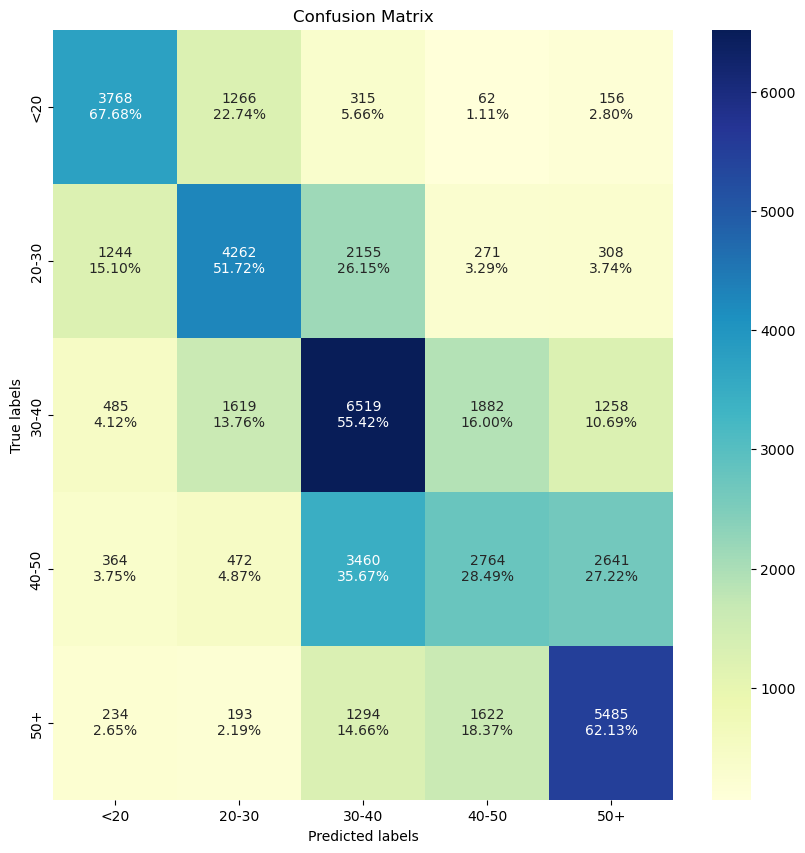

In [40]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
voting_preds_encoded = le.transform(voting_preds)

# get confusion matrix
cm = confusion_matrix(y_test, voting_preds)

# normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))

# create a heatmap with a color map of choice
# using zipped cm_norm and cm flatten arrays, 
# and rounding cm_norm to percentage, and cm to integer
annot = np.array([["{0:0.0f}\n{1:0.2%}".format(c, p) for c, p in zip(c_line, p_line)] 
                  for c_line, p_line in zip(cm, cm_norm)])

sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='YlGnBu', annot_kws={"size": 10})

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Define your class labels
class_labels = ['<20', '20-30', '30-40', '40-50', '50+']

ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.savefig("conf.png")
plt.show()

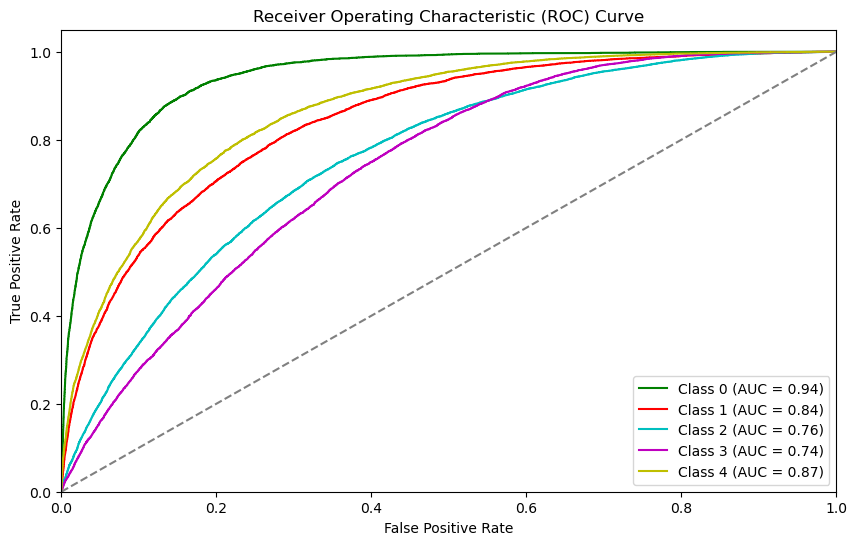

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], voting_preds_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['g', 'r', 'c', 'm', 'y']  

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [26]:
# Save the model
with open('voting_clf.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)